In [1]:
import numpy as np
import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words_abstract = 200
num_words_claims = 500
num_words_label_description = num_words_abstract+num_words_claims
directory_prefix = "../"
train_dataset_path = directory_prefix+'datasets/dataset2002-2020.csv'
test_dataset_path = directory_prefix+'datasets/claims_dataset_1.csv'
label_depth = 4
import random
#import gensim.downloader as api
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords


import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")
#embed = hub.load("https://tfhub.dev/google/Wiki-words-500/2")

embeddings = embed(["cat is on the mat", "dog is in the fog"])
embedding_dim = embeddings.shape[1]
#print(embeddings)
def get_sentence_vector(words, num_words):
    words = word_tokenize(remove_stopwords(words))
    #words = list(filter(lambda w: len(w)>2, words))
    ret = embed(words)
    ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),], [0, 0]]), "CONSTANT")
    ret = ret[:num_words]
    return ret
 
with open(directory_prefix+"/class_descriptions/class_descriptions_from_patents.pickle", 'rb') as f:
    label_dict = pickle.load(f)
label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_label_description) for k, val in label_dict.items()}
#label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/harpreet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
number_occurences=1000
def lstm_data_generator():
    occurences = {k:0 for k in label_dict.keys()}
    current_dataframe = pd.read_csv(train_dataset_path,sep=',', header = None).to_numpy()#, chunksize=100000)
    indices = np.random.choice(len(current_dataframe), len(current_dataframe)//20)
    for row in current_dataframe[indices]:
        if not isinstance(row[1], str) or not isinstance(row[2], str):
            continue
        label, description, claims=row
        lstm_input_patent = get_sentence_vector(description.lower(), num_words_abstract)
        lstm_input_claims = get_sentence_vector(claims.lower(), num_words_claims)
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = set([i for i in random.sample(label_dict_keys, min(len(label_vectors), len(label_dict.keys()))) if i not in label_vectors])
        #skip = False
        #for i in label_vectors:
        #    if occurences[i] >= number_occurences:
        #        skip = True
        #if skip:
        #    continue
        for l, k in zip((label_dict[i] for i in label_vectors), label_vectors):
            occurences[k] +=1
            yield ({'input_abstract':lstm_input_patent, 'input_claims':lstm_input_claims, 'input_label':l}, {'output_binary':[1]})
        for l, k in zip((label_dict[i] for i in non_true_vectors), non_true_vectors):
            occurences[k] +=1
            yield ({'input_abstract':lstm_input_patent, 'input_claims':lstm_input_claims, 'input_label':l}, {'output_binary':[0]})
        #if sum(occurences.values()) >= len(label_dict)*(number_occurences-10):
        #    print("\n\ndone with occurences\n\n")
        #    occurences = {k:0 for k in label_dict.keys()}
    return
description_shape = tf.TensorShape([num_words_abstract, embedding_dim])
claims_shape = tf.TensorShape([num_words_claims, embedding_dim])
label_shape = tf.TensorShape([num_words_label_description, embedding_dim])
lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_abstract':tf.float64, 'input_claims':tf.float64, 'input_label':tf.float64}, {'output_binary':tf.float64}), ({'input_abstract':description_shape,'input_claims':claims_shape, 'input_label':label_shape}, {'output_binary':tf.TensorShape([1])}))

#filename = train_dataset_path[:-4]+'.tfrecord'
#writer = tf.data.experimental.TFRecordWriter(filename)
#writer.write(lstm_dataset)

lstm_dataset = lstm_dataset.batch(128, drop_remainder=True).prefetch(100).repeat()

In [3]:
layer_size = 256
layer_size2 = 1024

input_abstract = tf.keras.Input(shape=(num_words_abstract, embedding_dim), name='input_abstract')
input_claims = tf.keras.Input(shape=(num_words_claims, embedding_dim), name='input_claims')
input_label = tf.keras.Input(shape=(num_words_label_description, embedding_dim), name='input_label')

abstract_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_abstract, embedding_dim))(input_abstract)
claims_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_claims, embedding_dim))(input_claims)
label_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_label_description, embedding_dim))(input_label)

abstractLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(abstract_mask)
claimsLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(claims_mask)
labelLSTM = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(label_mask)

abstractLSTM = tf.keras.layers.Dense(layer_size)(abstractLSTM)
claimsLSTM = tf.keras.layers.Dense(layer_size)(claimsLSTM)
labelLSTM = tf.keras.layers.Dense(layer_size)(labelLSTM)


abstract = tf.keras.layers.GlobalAveragePooling1D()(abstractLSTM)
claims = tf.keras.layers.GlobalAveragePooling1D()(claimsLSTM)
label = tf.keras.layers.GlobalAveragePooling1D()(labelLSTM)

concat = tf.keras.layers.Concatenate(axis=1)([abstract,claims,label])

dense = tf.keras.layers.Dense(int(layer_size2))(concat)
dense = tf.keras.layers.Dense(int(layer_size2), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size2), activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size2), activation='relu')(dense)

output_binary = tf.keras.layers.Dense(1, activation="sigmoid", name='output_binary')(dense)
model = tf.keras.Model(inputs={'input_abstract':input_abstract, 'input_claims':input_claims,  'input_label':input_label}, outputs=[output_binary])
print(model)

In [4]:
try:
    model.load_weights(directory_prefix+"checkpoints/lstm3head_label4.h5")
except:
    pass

model.summary()
opt = tf.optimizers.Adam(1e-4)
model.compile(loss=['binary_crossentropy'],
              optimizer=opt,
              metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"checkpoints/lstm3head_label4.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_abstract (InputLayer)     [(None, 200, 128)]   0                                            
__________________________________________________________________________________________________
input_claims (InputLayer)       [(None, 500, 128)]   0                                            
__________________________________________________________________________________________________
input_label (InputLayer)        [(None, 700, 128)]   0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 200, 128)     0           input_abstract[0][0]             
_______________________________________________________________________________________

546/546 [==============================] - 510s 934ms/step


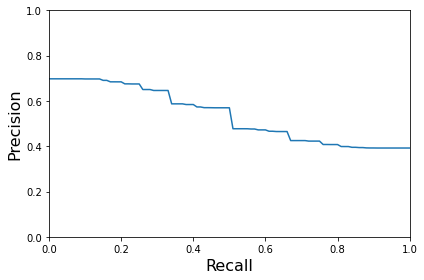

<Figure size 432x288 with 0 Axes>

In [5]:
def generate_prc():
    label_len = len(label_dict_keys)
    #print(label_len)
    left = [label_dict[i] for i in label_dict_keys]
    predictions = []
    left_vectors = np.array(list(label_dict_keys))
    label_vectors_vector = []
    num_tests = 546
    def cur_gen():
        current_dataframe = pd.read_csv(test_dataset_path,sep=',', header = None).to_numpy()#, chunksize=100000)
        indices = np.random.choice(len(current_dataframe), len(current_dataframe)-1)
        for row in current_dataframe[indices]:
            label, abstract, claims=row
            label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
            label_vectors = set([i for i in label_vectors if i in label_dict_keys])
            if label_vectors == set():
                continue
            label_vectors_vector.append(label_vectors)
            lstm_input_patent = get_sentence_vector(abstract.lower(), num_words_abstract)
            lstm_input_claims = get_sentence_vector(claims.lower(), num_words_claims)
            for i in left:
                yield ({'input_abstract':lstm_input_patent, 'input_claims':lstm_input_claims, 'input_label':i})
    description_shape = tf.TensorShape([num_words_abstract, embedding_dim])
    claims_shape = tf.TensorShape([num_words_claims, embedding_dim])
    dataset = tf.data.Dataset.from_generator(cur_gen, ({'input_abstract':tf.float64, 'input_claims':tf.float64, 'input_label':tf.float64}), ({'input_abstract':description_shape,'input_claims':claims_shape, 'input_label':label_shape}))
    dataset = dataset.batch(label_len).prefetch(50)
    predictions = model.predict(dataset, steps=num_tests, verbose=1).reshape(num_tests, label_len)
    n = 0
    d=0
    recalls = np.arange(0, 1.01, .01)
    ns = []
    
    for prediction, label_vectors in zip(predictions, label_vectors_vector):
        indices = np.flip(np.argsort(prediction, axis=0))
        #print(indices)
        e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
        cur = []
        total_ones = e.count(1)
        n = 0
        ones_seen = 0
        while ones_seen < total_ones:
            if e[n] == 1:
                ones_seen = ones_seen+1
            n = n+1
            cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
        new_cur = []
        for r in recalls:
            max_of_larger = max([i[0] for i in cur if i[1] >= r])
            new_cur.append(max_of_larger)
        ns.append(new_cur)
        #print(max(new_cur))
        d = d+1
        #print(float(d)/7215)
        #print(np.mean(np.vstack(ns), axis=0)[0])
    p = np.mean(np.array(ns), axis=0)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    #plt.plot(recalls, p_baseline, 'r')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    #print(p) 
    plt.savefig('binary_prc1.eps', format='eps')
generate_prc()

Epoch 1/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9412
Epoch 00001: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 532s 974ms/step


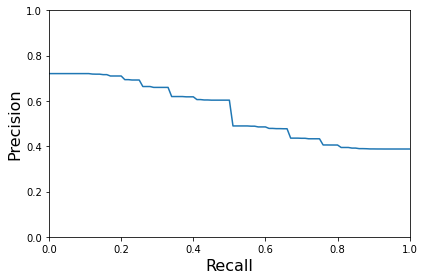

2000/2000 [==============================] - 2236s 1s/step - loss: 0.1514 - accuracy: 0.9412
Epoch 2/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9431
Epoch 00002: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 536s 983ms/step


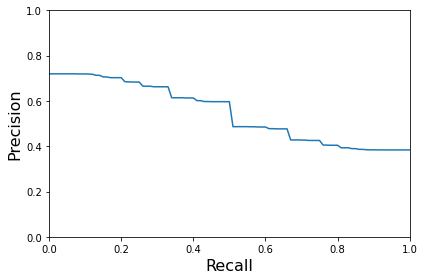

2000/2000 [==============================] - 2167s 1s/step - loss: 0.1487 - accuracy: 0.9431
Epoch 3/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9427
Epoch 00003: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 531s 973ms/step


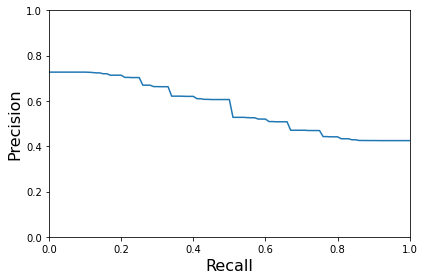

2000/2000 [==============================] - 2328s 1s/step - loss: 0.1499 - accuracy: 0.9427
Epoch 4/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1499 - accuracy: 0.9422
Epoch 00004: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 527s 965ms/step


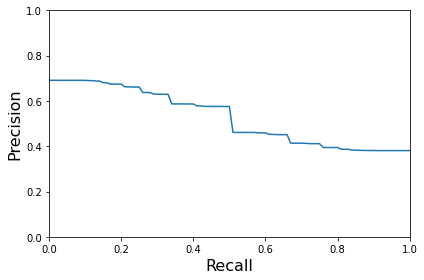

2000/2000 [==============================] - 2160s 1s/step - loss: 0.1499 - accuracy: 0.9422
Epoch 5/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1943 - accuracy: 0.9174
Epoch 00005: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 532s 974ms/step


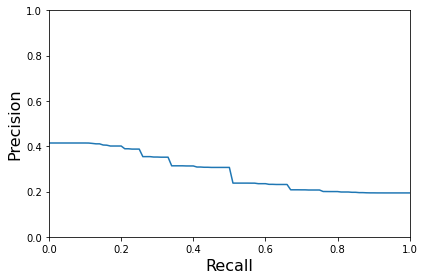

2000/2000 [==============================] - 2168s 1s/step - loss: 0.1943 - accuracy: 0.9174
Epoch 6/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1912 - accuracy: 0.9232
Epoch 00006: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 531s 973ms/step


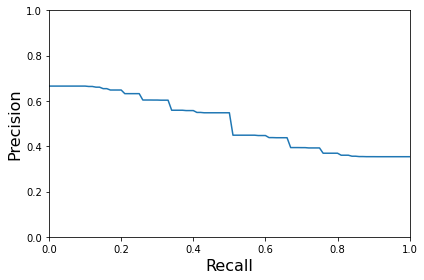

2000/2000 [==============================] - 2346s 1s/step - loss: 0.1912 - accuracy: 0.9232
Epoch 7/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1611 - accuracy: 0.9375
Epoch 00007: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 525s 962ms/step


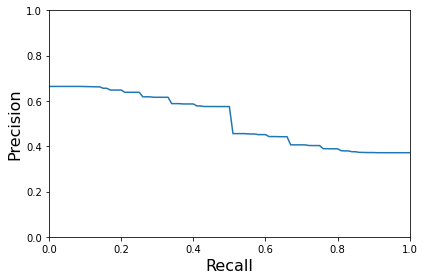

2000/2000 [==============================] - 2171s 1s/step - loss: 0.1611 - accuracy: 0.9375
Epoch 8/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9381
Epoch 00008: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 518s 949ms/step


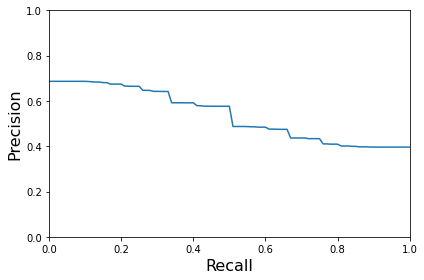

2000/2000 [==============================] - 2168s 1s/step - loss: 0.1585 - accuracy: 0.9381
Epoch 9/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1570 - accuracy: 0.9391
Epoch 00009: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 548s 1s/step


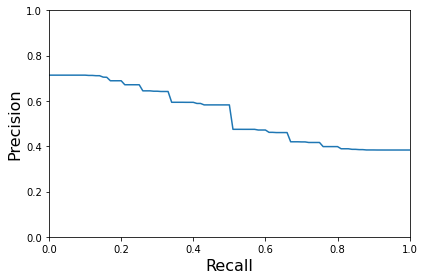

2000/2000 [==============================] - 2399s 1s/step - loss: 0.1570 - accuracy: 0.9391
Epoch 10/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9396
Epoch 00010: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 529s 968ms/step


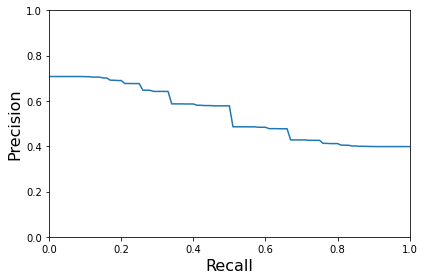

2000/2000 [==============================] - 2209s 1s/step - loss: 0.1563 - accuracy: 0.9396
Epoch 11/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9406
Epoch 00011: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 544s 996ms/step


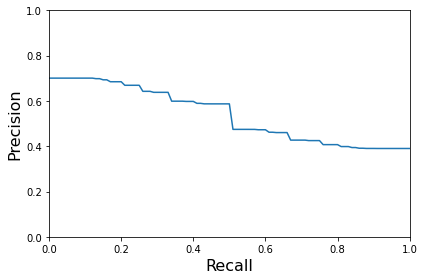

2000/2000 [==============================] - 2395s 1s/step - loss: 0.1544 - accuracy: 0.9406
Epoch 12/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9406
Epoch 00012: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 523s 958ms/step


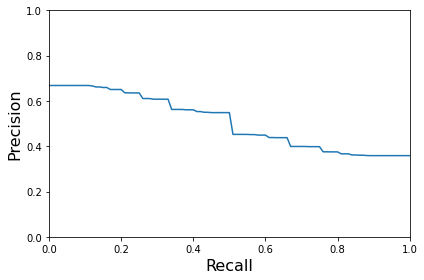

2000/2000 [==============================] - 2181s 1s/step - loss: 0.1540 - accuracy: 0.9406
Epoch 13/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9417
Epoch 00013: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 526s 963ms/step


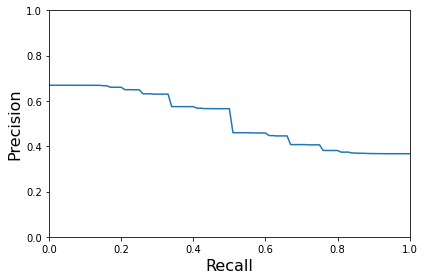

2000/2000 [==============================] - 2174s 1s/step - loss: 0.1509 - accuracy: 0.9417
Epoch 14/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9426
Epoch 00014: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 535s 980ms/step


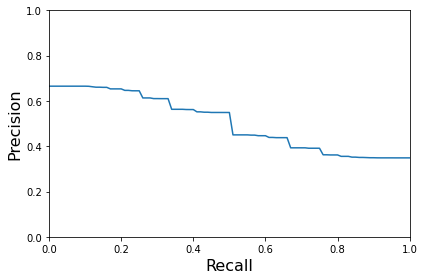

2000/2000 [==============================] - 2359s 1s/step - loss: 0.1485 - accuracy: 0.9426
Epoch 15/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1470 - accuracy: 0.9433
Epoch 00015: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 525s 962ms/step


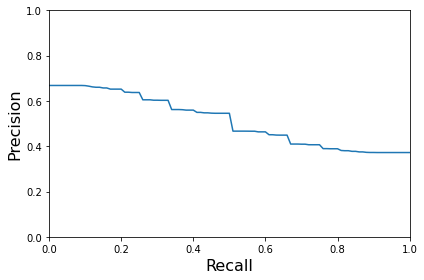

2000/2000 [==============================] - 2184s 1s/step - loss: 0.1470 - accuracy: 0.9433
Epoch 16/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9444
Epoch 00016: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 506s 926ms/step


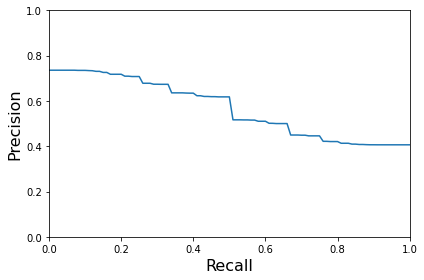

2000/2000 [==============================] - 2159s 1s/step - loss: 0.1449 - accuracy: 0.9444
Epoch 17/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9424
Epoch 00017: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 539s 987ms/step


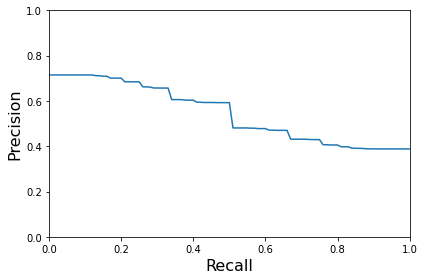

2000/2000 [==============================] - 2397s 1s/step - loss: 0.1489 - accuracy: 0.9424
Epoch 18/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1443 - accuracy: 0.9445
Epoch 00018: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 529s 970ms/step


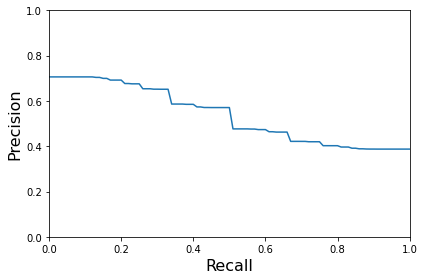

2000/2000 [==============================] - 2191s 1s/step - loss: 0.1443 - accuracy: 0.9445
Epoch 19/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1431 - accuracy: 0.9450
Epoch 00019: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 545s 998ms/step


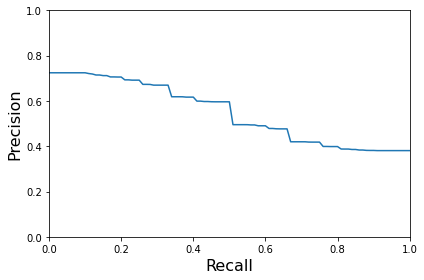

2000/2000 [==============================] - 2374s 1s/step - loss: 0.1431 - accuracy: 0.9450
Epoch 20/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9461
Epoch 00020: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 526s 964ms/step


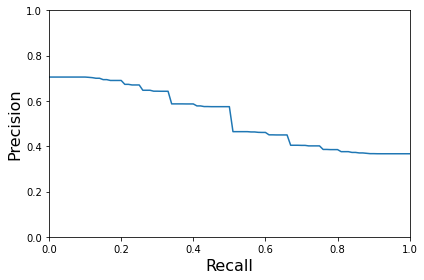

2000/2000 [==============================] - 2191s 1s/step - loss: 0.1411 - accuracy: 0.9461
Epoch 21/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9451
Epoch 00021: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 523s 958ms/step


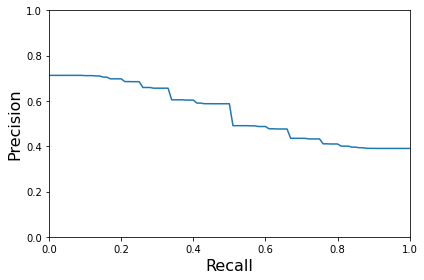

2000/2000 [==============================] - 2177s 1s/step - loss: 0.1433 - accuracy: 0.9451
Epoch 22/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9458
Epoch 00022: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 540s 990ms/step


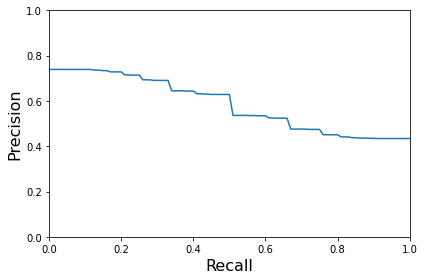

2000/2000 [==============================] - 2374s 1s/step - loss: 0.1423 - accuracy: 0.9458
Epoch 23/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9462
Epoch 00023: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 522s 956ms/step


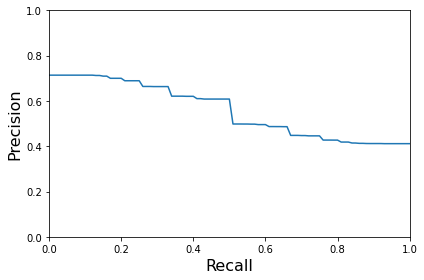

2000/2000 [==============================] - 2184s 1s/step - loss: 0.1401 - accuracy: 0.9462
Epoch 24/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9469
Epoch 00024: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 519s 951ms/step


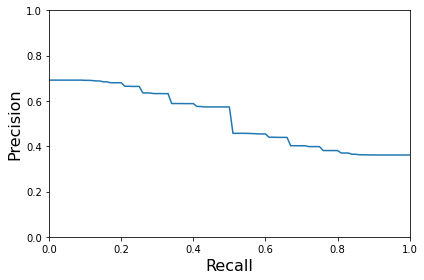

2000/2000 [==============================] - 2180s 1s/step - loss: 0.1388 - accuracy: 0.9469
Epoch 25/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9471
Epoch 00025: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 538s 985ms/step


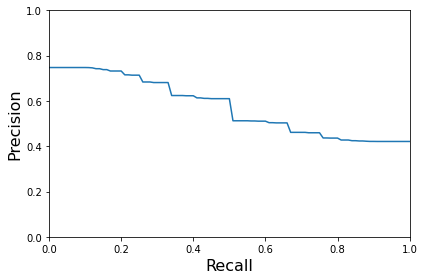

2000/2000 [==============================] - 2486s 1s/step - loss: 0.1381 - accuracy: 0.9471
Epoch 26/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9468
Epoch 00026: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 520s 952ms/step


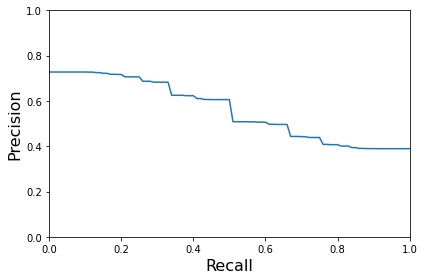

2000/2000 [==============================] - 2180s 1s/step - loss: 0.1400 - accuracy: 0.9468
Epoch 27/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9471
Epoch 00027: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 533s 977ms/step


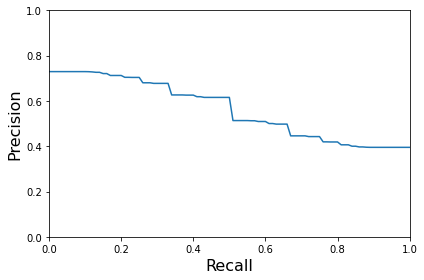

2000/2000 [==============================] - 2370s 1s/step - loss: 0.1391 - accuracy: 0.9471
Epoch 28/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1395 - accuracy: 0.9466
Epoch 00028: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 522s 956ms/step


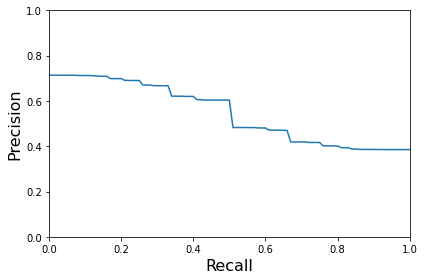

2000/2000 [==============================] - 2180s 1s/step - loss: 0.1395 - accuracy: 0.9466
Epoch 29/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1384 - accuracy: 0.9471
Epoch 00029: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 523s 958ms/step


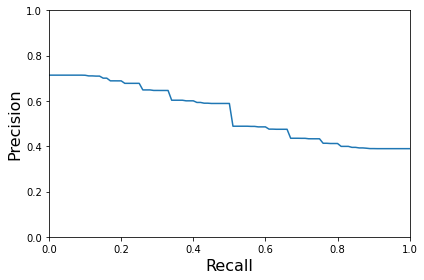

2000/2000 [==============================] - 2180s 1s/step - loss: 0.1384 - accuracy: 0.9471
Epoch 30/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1361 - accuracy: 0.9481
Epoch 00030: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 543s 994ms/step


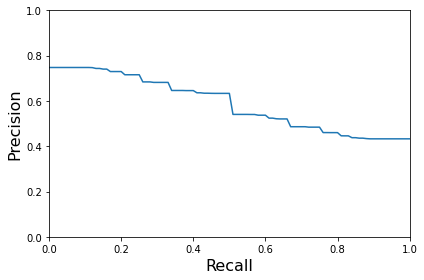

2000/2000 [==============================] - 2378s 1s/step - loss: 0.1361 - accuracy: 0.9481
Epoch 31/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1371 - accuracy: 0.9476
Epoch 00031: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 529s 969ms/step


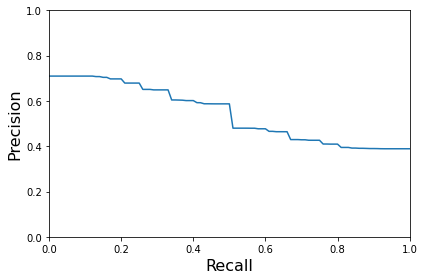

2000/2000 [==============================] - 2194s 1s/step - loss: 0.1371 - accuracy: 0.9476
Epoch 32/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9474
Epoch 00032: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 518s 950ms/step


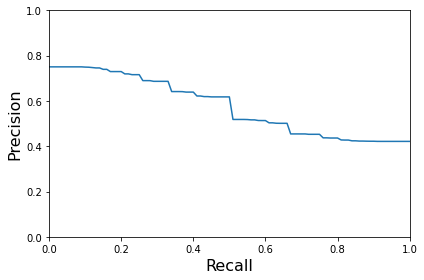

2000/2000 [==============================] - 2181s 1s/step - loss: 0.1378 - accuracy: 0.9474
Epoch 33/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9476
Epoch 00033: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 550s 1s/step


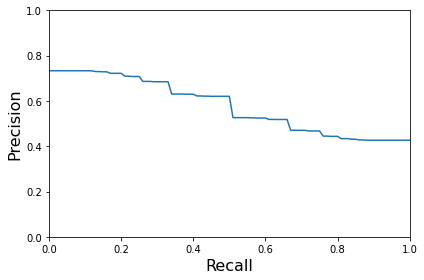

2000/2000 [==============================] - 2391s 1s/step - loss: 0.1368 - accuracy: 0.9476
Epoch 34/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.9481
Epoch 00034: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 529s 969ms/step


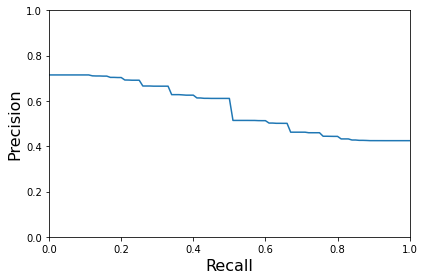

2000/2000 [==============================] - 2190s 1s/step - loss: 0.1377 - accuracy: 0.9481
Epoch 35/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.9482
Epoch 00035: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 538s 985ms/step


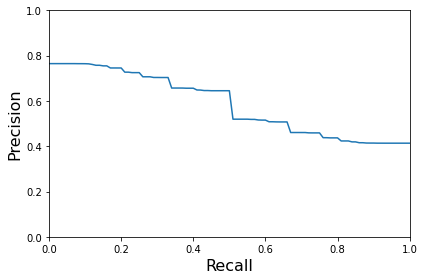

2000/2000 [==============================] - 2377s 1s/step - loss: 0.1364 - accuracy: 0.9482
Epoch 36/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1370 - accuracy: 0.9476
Epoch 00036: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 519s 951ms/step


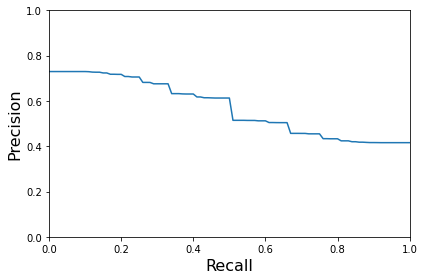

2000/2000 [==============================] - 2180s 1s/step - loss: 0.1370 - accuracy: 0.9476
Epoch 37/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9488
Epoch 00037: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 522s 956ms/step


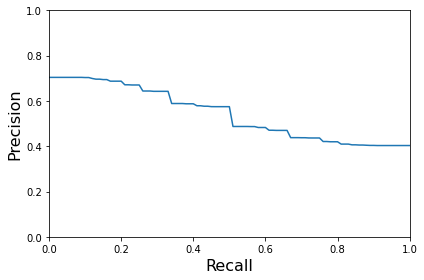

2000/2000 [==============================] - 2177s 1s/step - loss: 0.1347 - accuracy: 0.9488
Epoch 38/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1343 - accuracy: 0.9491
Epoch 00038: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 533s 976ms/step


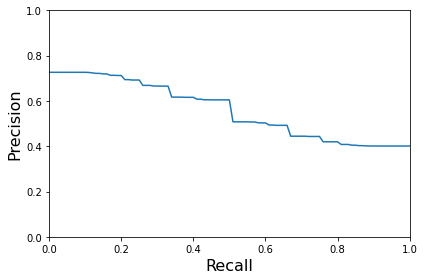

2000/2000 [==============================] - 2472s 1s/step - loss: 0.1343 - accuracy: 0.9491
Epoch 39/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1358 - accuracy: 0.9485
Epoch 00039: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 519s 951ms/step


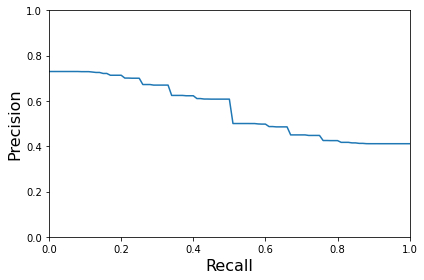

2000/2000 [==============================] - 2177s 1s/step - loss: 0.1358 - accuracy: 0.9485
Epoch 40/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1351 - accuracy: 0.9483
Epoch 00040: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 526s 964ms/step


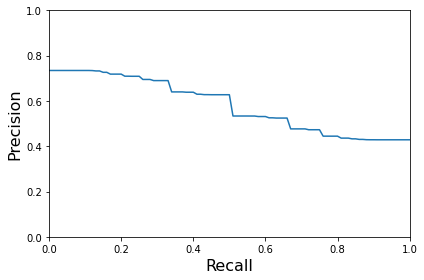

2000/2000 [==============================] - 2183s 1s/step - loss: 0.1351 - accuracy: 0.9483
Epoch 41/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1346 - accuracy: 0.9487
Epoch 00041: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 546s 999ms/step


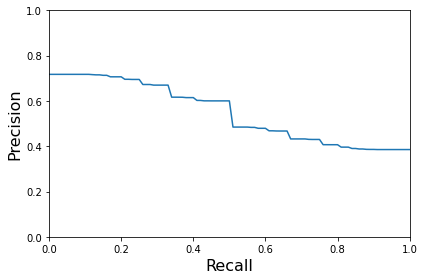

2000/2000 [==============================] - 2376s 1s/step - loss: 0.1346 - accuracy: 0.9487
Epoch 42/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1327 - accuracy: 0.9496
Epoch 00042: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 528s 966ms/step


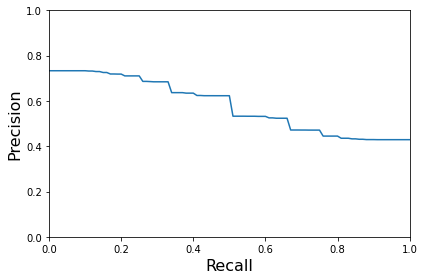

2000/2000 [==============================] - 2185s 1s/step - loss: 0.1327 - accuracy: 0.9496
Epoch 43/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1335 - accuracy: 0.9491
Epoch 00043: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 544s 996ms/step


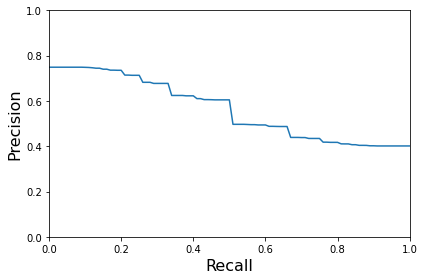

2000/2000 [==============================] - 2388s 1s/step - loss: 0.1335 - accuracy: 0.9491
Epoch 44/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9488
Epoch 00044: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 523s 958ms/step


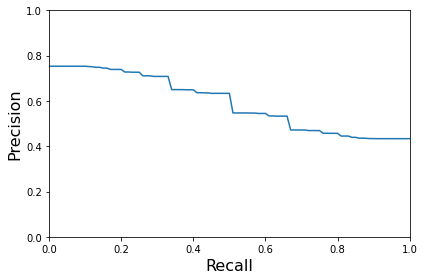

2000/2000 [==============================] - 2189s 1s/step - loss: 0.1341 - accuracy: 0.9488
Epoch 45/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1336 - accuracy: 0.9494
Epoch 00045: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 518s 948ms/step


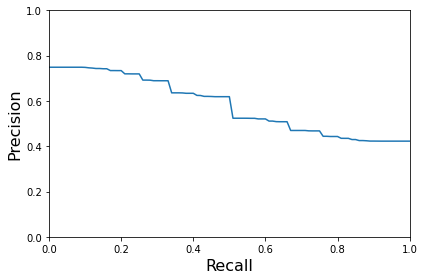

2000/2000 [==============================] - 2177s 1s/step - loss: 0.1336 - accuracy: 0.9494
Epoch 46/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.9498
Epoch 00046: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 527s 966ms/step


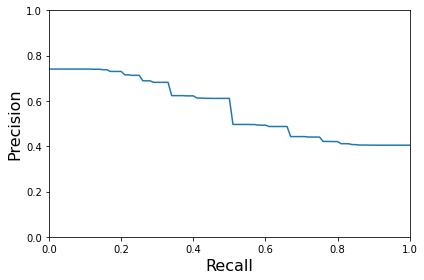

2000/2000 [==============================] - 2361s 1s/step - loss: 0.1325 - accuracy: 0.9498
Epoch 47/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1308 - accuracy: 0.9505
Epoch 00047: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 525s 961ms/step


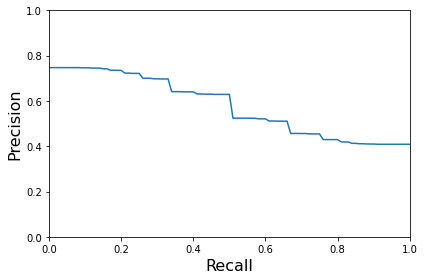

2000/2000 [==============================] - 2174s 1s/step - loss: 0.1308 - accuracy: 0.9505
Epoch 48/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1329 - accuracy: 0.9496
Epoch 00048: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 514s 941ms/step


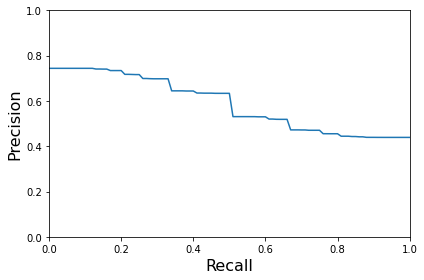

2000/2000 [==============================] - 2169s 1s/step - loss: 0.1329 - accuracy: 0.9496
Epoch 49/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1322 - accuracy: 0.9496
Epoch 00049: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 535s 979ms/step


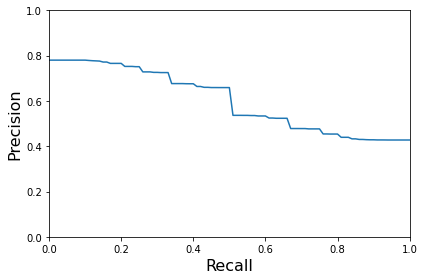

2000/2000 [==============================] - 2373s 1s/step - loss: 0.1322 - accuracy: 0.9496
Epoch 50/50
2000/2000 [==============================] - ETA: 0s - loss: 0.1317 - accuracy: 0.9499
Epoch 00050: saving model to ../checkpoints/lstm3head_label4.h5
546/546 [==============================] - 525s 961ms/step


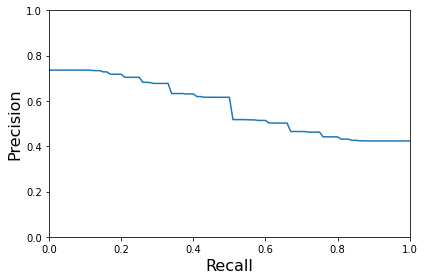

2000/2000 [==============================] - 2190s 1s/step - loss: 0.1317 - accuracy: 0.9499


<Figure size 432x288 with 0 Axes>

In [6]:
history = model.fit(lstm_dataset, epochs=50, steps_per_epoch=2000, callbacks=[cp_callback, prc_callback])